# Analysis of New York City COVID-19 Cases by Zip Code
## Introduction
$\;\;\;\;\;\;$ This notebook explains the incidence of COVID-19 cases in New York City (NYC) by leveraging Foursquare data on social venues across the 177 zip codes contained within the city's borders. In the early months of 2020 NYC was the global epicenter of the virus, and at the time of writing represents 4.5% of all COVID-19 cases worldwide, and 13.4% of cases in the United States. Nevertheless, the city is witnessing a clear downward trend in daily new cases reported: on May 8th only 425 new cases were identified, down from a peak of 6,213 on April 6th. This ebb is likely due to aggressive measures enacted by state and local policymakers. On March 22nd Governor Andrew Cuomo instituted a state-wide lockdown which mandated the closure of all nonessential businesses; leaving only grocery stores, pharmacies and other essential operations open. All non-solitary outside activities, including team sports, were also banned.<br>
$\;\;\;\;\;\;$ While these stringent restrictions have doubtlessly played an important role in stemming the tide of new cases, their macroeconomic effects cannot be overlooked. Over the course of the last five weeks, data from the New York Department of Labor reveal that the total number of New Yorkers filing new jobless claims has reached 1.4 million. This is roughly two-thirds  the total jobless claims filed during the entire span of the Great Recession, which lasted from June 2007-November 2009. Adding these 1.4 million jobless filers to those who had previously filed in the months before the COVID-19 crisis began now puts New York state’s unemployment rate at about 13%. This level of unemployment breaks the previous seasonally adjusted post-Great Depression record of 10.3% in February 1976, and does not take into account the sizable population of workers who are underemployed. To put this in perspective, during the Great Depression New York state’s peak unemployment rate was about 23%.<br>
$\;\;\;\;\;\;$ Given the severe economic consequences of the mandated lockdown, and the encouraging trend in new cases reported, there is currently a robust debate among New York state policymakers about whether such drastic measures are still necessary. Health officials continually warn that a headlong rush to reopen businesses, if not done in a cautious and sensible manner, could lead to a re-emergence of the virus that once again overwhelms the healthcare infrastructure of the city. Therefore, an understanding of the types of activities and social venues most strongly correlated with the initial spread of COVID-19 could help inform policymakers' decisionmaking about which businesses can be re-opened, while still maintaining a tolerable level of risk of a subsequent outbreak. The following analysis does exactly this and, using Foursquare data on social venues across the 177 zip codes of NYC, explains which venues are the best predictors of positive cases of COVID-19.  

## Data
$\;\;\;\;\;\;$The dependent variables in the analysis are the total number of positive COVID-19 cases, the ratio of positive tests to total tests administered and the growth rate in positive cases between 4/1/2020 (the earliest date available) and 5/12/2020 (date of writing), segmented by NYC zip code. These data are assembled by the NYC Department of Health and Mental Hygiene (DOHMH) Incident Command System for COVID-19 Response (Surveillance and Epidemiology Branch in collaboration with Public Information Office Branch), and are uploaded to GitHub daily. It should be noted that, due to the fact that this information is being collected in real-time, it is by definition preliminary and subject to change as the COVID-19 response continues. The analysis focuses on reported COVID-19 cases as of 4/1/2020, the earliest date avaialable, in order to investigate which venues most strongly contributed to the initial spread of the virus while minimizing the confounding effect of the lockdown. It seems reasonable to conclude that this effect is minimal, as the state-wide closure of businesses had been implemented only 10 days prior to the date the data was compiled.
<br>
$\;\;\;\;\;\;$ Given the fact that the population of an area is an important predictor of disease transmission generally, this variable is used as a control throughout the analysis. These data are taken from U.S. Census Bureau, as reported here: https://www.newyork-demographics.com/zip_codes_by_population. Including this variable in predictive models ensures that any inferences made about the types of venues associated with positive COVID-19 cases are not simply an artifact of the size of the population in a given zip code. This variable is also included in regressions which take the ratio of positive to total tests as the dependent variable, in order to account for heterogeneity in public testing resources available, which are likely correlated with population.<br>
$\;\;\;\;\;\;$ Lastly, the independent variables of interest throughout the analysis are the total number of social venues located in each NYC zip code, as categorized by the author. These data are retrieved from the venues group of the Foursquare API by first assigning each zip code centroid in NYC a latitude and longitude using the geocoder library, and then inputting these coordinates into formatted queries. The results are limited to a radius of 500 meters from the coordinates inputted, and duplicates are removed whenever radii overlap. The final variables are the total number of venues in a given zip code categorized as a hotel, restaurant, transportation terminal, store, market or recreational venue. These variables are generated through string searches of the venue categories returned by the API. The variable **Market**, for example, is the total number of venues in a given zip code with "market", "grocery", "supermarket", etc. listed in the venue category. The role each of these types of venues play in the transmission of COVID-19 will be analyzed in the regression analysis below.

In [61]:
#Import libraries
import pandas as pd
import numpy as np
import json
import requests
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
import folium
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
!pip install geocoder
import geocoder

print('Libraries imported.')
df_reg=pd.read_pickle(r"C:\Users\ianpa\Desktop\Work\Learning\IBM\Data\saved\df_reg_20200512_nogas.pkl")
df_reg.drop(columns=["cases_april", "tests_april", "cases_may", "tests_may", "Latitude", "Longitude", "School", "Total", "ZIP"], inplace=True)
df_reg.describe()

Libraries imported.


Population       Hotel  Transportation       Store      Market  \
count     177.000000  177.000000      177.000000  177.000000  177.000000   
mean    47645.062147    0.435028        0.672316    6.649718    2.259887   
std     26698.398778    1.053950        1.120558    6.225991    1.994374   
min      3028.000000    0.000000        0.000000    0.000000    0.000000   
25%     27403.000000    0.000000        0.000000    2.000000    1.000000   
50%     42653.000000    0.000000        0.000000    5.000000    2.000000   
75%     67094.000000    0.000000        1.000000   10.000000    4.000000   
max    112425.000000    7.000000        6.000000   26.000000    9.000000   

       Restaurant         Bar  Recreation  
count  177.000000  177.000000  177.000000  
mean    18.457627    2.677966    6.107345  
std     17.143103    4.011804    7.450961  
min      0.000000    0.000000    0.000000  
25%      5.000000    0.000000    1.000000  
50%     12.000000    1.000000    3.000000  
75%     28.000000    4.000000    9.000000  
max     65.000000   23.000000   44.000000

## Data Collection and Processing

I begin by scraping GitHub for Covid-19 data by New York City zip code. The earliest data available (uploaded April 1st) and the most recent data available (uploaded May 12th) are extracted. I then retrieve NYC population data, as well as neighborhood and borough names, and then assign geographic coordinates to each zip code using the geocoder library. Examining the shape of the resulting datasets ensures each zip code listed in the COVID-19 data is retained. Borough and neighborhood names are hard-coded for 6 of the zip codes after verifying that they are in fact within the city's borders:

In [12]:
#April 1st COVID-19 data
url_covid_april="https://github.com/nychealth/coronavirus-data/blob/097cbd70aa00eb635b17b177bc4546b2fce21895/tests-by-zcta.csv"
results_covid_april=pd.read_html(url_covid_april)
df_covid_april=results_covid_april[0]

#remove unnecessary columns
df_covid_april.drop(columns=["Unnamed: 0"], inplace=True)

#format zip code column
df_covid_april.rename(columns={"MODZCTA": "zip_code", "Positive": "cases_april", "Total": "tests_april"}, inplace=True)
df_covid_april.dropna(inplace=True)
df_covid_april=df_covid_april.astype('int64')
print("Total number of NYC Covid-19 cases as of 4/1/2020:", df_covid_april['cases_april'].sum())
print("The shape of the April COVID-19 dataframe is:", df_covid_april.shape)

#May COVID-19 data
url_covid_may="https://github.com/nychealth/coronavirus-data/blob/master/tests-by-zcta.csv" 
results_covid_may=pd.read_html(url_covid_may)
df_covid_may=results_covid_may[0]

#remove unnecessary columns
df_covid_may.drop(columns=["Unnamed: 0", "zcta_cum.perc_pos"], inplace=True)

#format zip code column
df_covid_may.rename(columns={"MODZCTA": "zip_code", "Positive": "cases_may", "Total": "tests_may"}, inplace=True)
df_covid_may.dropna(inplace=True)
df_covid_may=df_covid_may.astype('int64')
print("Total number of NYC Covid-19 cases as of 5/12/2020:", df_covid_may['cases_may'].sum())
print("The shape of the May COVID-19 dataframe is:", df_covid_may.shape)

#merge April 1st and May 12th data
df_covid=pd.merge(df_covid_april, df_covid_may,left_on='zip_code', right_on='zip_code', validate='1:1')
assert df_covid.shape[0]==177

#check missing values
print("Missing data by column:", df_covid.isnull().sum())

#Population Data
url_pop="https://www.newyork-demographics.com/zip_codes_by_population"
results_pop=pd.read_html(url_pop)
df_pop=results_pop[0]
df_pop.rename(columns={"Zip Code": "zip_code"}, inplace=True)
df_pop.drop(columns=["Rank"], inplace=True)
df_pop.drop(df_pop.tail(1).index,inplace=True)

#Format
new_pop=(df_pop.set_index(df_pop.columns.drop('zip_code',1).tolist())
        .zip_code.str.split('and',expand=True)
        .stack()
        .reset_index()
        .rename(columns={0:'zip_code'})
        .loc[:,df_pop.columns]
       )

new_pop.drop(new_pop[new_pop['zip_code'].str.contains(',')==True].index,inplace=True)
new_pop=new_pop.astype('int64')

#merge onto COVID-19 data
df_inter=pd.merge(df_covid, new_pop,on='zip_code', how='left', validate='1:m')
assert df_inter.shape[0]==177

#Neighborhood and borough names
url_names="https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm"
results_names=pd.read_html(url_names)
df_names=results_names[0]
df_names.rename(columns={"ZIP Codes": "zip_code"}, 
                inplace=True)

#Format
new_df=(df_names.set_index(df_names.columns.drop('zip_code',1).tolist())
        .zip_code.str.split(',',expand=True)
        .stack()
        .reset_index()
        .rename(columns={0:'zip_code'})
        .loc[:,df_names.columns]
       )

new_df['zip_code']=new_df['zip_code'].astype('int64')

#merge
df=pd.merge(df_inter, new_df,on='zip_code', how='left', validate='1:m')
assert df.shape[0]==177
print("The shape of the resulting dataframe is (check that matches Covid-19 data):", df.shape)

#code missing neighborhoods and borough names
df.iloc[43, 6]="Manhattan" 
df.iloc[43, 7]="Lower Manhattan" 
df.iloc[39, 6]="Manhattan"
df.iloc[39, 7]="Upper West Side"
df.iloc[89, 6]="Queens"
df.iloc[89, 7]="Northwest Queens"

#check missing values
print("Missing data by column:", df.isnull().sum())

#define function to retrieve coordinates based on zip code
df['zip_code']=df['zip_code'].astype('str')
def get_latlon(ZIP):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, New York City, New York'.format(ZIP))
        lat_lng_coords = g.latlng
    return lat_lng_coords

#add empty columns and iterate over rows to fill coordinates
df['Latitude']=np.nan
df['Longitude']=np.nan
for row_index,row in df.iterrows():
    cord=get_latlon(row['zip_code'])
    #print(row['zip_code'],cord)
    df.loc[row_index,'Latitude']=cord[0]
    df.loc[row_index,'Longitude']=cord[1]


#save resulting dataframe
df.to_pickle(r"C:\Users\ianpa\Desktop\Work\Learning\IBM\Data\saved\nyc_cases_20200516.pkl")

Total number of NYC Covid-19 cases as of 4/1/2020: 38904
The shape of the April COVID-19 dataframe is: (177, 3)
Total number of NYC Covid-19 cases as of 5/12/2020: 183956
The shape of the May COVID-19 dataframe is: (177, 3)
Missing data by column: zip_code       0
cases_april    0
tests_april    0
cases_may      0
tests_may      0
dtype: int64
The shape of the resulting dataframe is (check that matches Covid-19 data): (177, 8)
Missing data by column: zip_code        0
cases_april     0
tests_april     0
cases_may       0
tests_may       0
Population      0
Borough         0
Neighborhood    0
dtype: int64


Using the geographic coordinates derived above, I now retrieve fousquare venues data for each NYC zip code:

In [5]:
CLIENT_ID = 'SDCNWVQ20RISRQVXCIWQP1NRT0XWZTHXSEI4NKCAOH0D1LGE' # your Foursquare ID
CLIENT_SECRET = 'FCRTWP1WTSVFPLC0NTJV32RJTW1GTBBNC0VJSWR5EVMEV1MY' # your Foursquare Secret
VERSION = '20200511'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

LIMIT = 1 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
def getNearbyVenues_loop(names, codes, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, code, lat, lng in zip(names, codes, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            code,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            #v['venue']['location']['postalCode'],
            v['venue']['categories'][0]['name']) for v in results])  

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood ZIP',          
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  #'Venue Zip',           
                  'Venue Category']
    
    return(nearby_venues)

nyc_venues = getNearbyVenues_loop(names=df['Neighborhood'],
                                   codes=df['zip_code'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )
df.to_pickle(r"C:\Users\ianpa\Desktop\Work\Learning\IBM\Data\saved\nyc_venues_20200516.pkl")

Your credentails:
CLIENT_ID: SDCNWVQ20RISRQVXCIWQP1NRT0XWZTHXSEI4NKCAOH0D1LGE
CLIENT_SECRET:FCRTWP1WTSVFPLC0NTJV32RJTW1GTBBNC0VJSWR5EVMEV1MY


Having extracted the Foursquare data, I drop duplicates from overlapping radii and then create indicator variables for each category of venue using string searches. Assertions within the code ensure that each venue returned is allocated to at most one category. These indicators are then summed to obtain the total number of each type of venue by zip code. This dataframe is then merged with the COVID-19 data derived above, and then formatted to prepare for the regression analysis:

In [42]:
### re-load data
nyc=pd.read_pickle(r"C:\Users\ianpa\Desktop\Work\Learning\IBM\Data\saved\nyc_venues_20200512.pkl")
nyc.rename(columns={"Neighborhood ZIP": "ZIP"}, inplace=True)

#drop duplicates
print("shape before duplicate drop:", nyc.shape)
nyc = nyc.drop_duplicates(subset=['Venue', 'Venue Longitude', 'Venue Latitude'], keep='last')
print("shape after duplicate drop:", nyc.shape)

#Hotels: Bed & Breakfast
nyc["Hotel"]=0
nyc["Hotel"]=((nyc["Venue Category"].str.contains("Hotel", regex=True) &
~nyc["Venue Category"].str.contains("Bar", regex=True)) |
nyc["Venue Category"].str.contains("Hostel", regex=True) |              
nyc["Venue Category"].str.contains("Bed & Breakfast", regex=True)).astype(int)

#Transportation: Remove gas stations
nyc["Transportation"]=0
nyc["Transportation"]=((nyc["Venue Category"].str.contains("Bus", regex=True) &
~nyc["Venue Category"].str.contains("Business", regex=True)) |
nyc["Venue Category"].str.contains("Metro", regex=True) |   
(nyc["Venue Category"].str.contains("Station", regex=True) &
~nyc["Venue Category"].str.contains("Gas", regex=True)) |
nyc["Venue Category"].str.contains("Heliport", regex=True) |
nyc["Venue Category"].str.contains("Boat", regex=True) |
nyc["Venue Category"].str.contains("Train", regex=True)).astype(int)                    
                    
#Store: 
nyc["Store"]=0
nyc["Store"]=(nyc["Venue Category"].str.contains("Wine Shop", regex=True) |
nyc["Venue Category"].str.contains("Cosmetics Shop", regex=True) |
nyc["Venue Category"].str.contains("Supplement Shop", regex=True) |
nyc["Venue Category"].str.contains("Sporting Goods", regex=True) |
nyc["Venue Category"].str.contains("Garden Center", regex=True) |
nyc["Venue Category"].str.contains("Pharmacy", regex=True) |
nyc["Venue Category"].str.contains("Liquor Store", regex=True) |              
nyc["Venue Category"].str.contains("Mobile Phone Shop", regex=True) |
nyc["Venue Category"].str.contains("Department Store", regex=True) |              
nyc["Venue Category"].str.contains("Clothing Store", regex=True) |              
nyc["Venue Category"].str.contains("Discount Store", regex=True) |              
nyc["Venue Category"].str.contains("Convenience Store", regex=True) |               
nyc["Venue Category"].str.contains("Bookstore", regex=True) |               
nyc["Venue Category"].str.contains("Pet Store", regex=True) |               
nyc["Venue Category"].str.contains("Shoe Store", regex=True) |               
nyc["Venue Category"].str.contains("Furniture / Home Store", regex=True) | 
nyc["Venue Category"].str.contains("Gift Shop", regex=True) | 
nyc["Venue Category"].str.contains("Boutique", regex=True) |               
nyc["Venue Category"].str.contains("Video Game Store", regex=True) |               
nyc["Venue Category"].str.contains("Kids Store", regex=True) |               
nyc["Venue Category"].str.contains("Shopping Mall", regex=True) |               
nyc["Venue Category"].str.contains("Supplement Shop ", regex=True) |               
nyc["Venue Category"].str.contains("Sporting Goods Shop ", regex=True) | 
nyc["Venue Category"].str.contains("Vape Store", regex=True) |               
nyc["Venue Category"].str.contains("Tanning Salon", regex=True) |               
nyc["Venue Category"].str.contains("Newsstand", regex=True) |               
nyc["Venue Category"].str.contains("Car Wash", regex=True) |               
nyc["Venue Category"].str.contains("Used Bookstore", regex=True) |               
nyc["Venue Category"].str.contains("Motorcycle Shop", regex=True) | 
nyc["Venue Category"].str.contains("Auto Dealership", regex=True) |               
nyc["Venue Category"].str.contains("Post Office", regex=True) |               
nyc["Venue Category"].str.contains("Adult Boutique", regex=True) |               
nyc["Venue Category"].str.contains("Luggage Store", regex=True) |               
nyc["Venue Category"].str.contains("Duty-free Shop", regex=True) | 
nyc["Venue Category"].str.contains("Shopping Plaza", regex=True) |               
nyc["Venue Category"].str.contains("Print Shop", regex=True) |               
nyc["Venue Category"].str.contains("Bike Shop", regex=True) |               
nyc["Venue Category"].str.contains("Dentist's Office", regex=True) |               
nyc["Venue Category"].str.contains("Physical Therapist", regex=True) | 
nyc["Venue Category"].str.contains("Fabric Shop", regex=True) | 
nyc["Venue Category"].str.contains("Outdoor Supply Store", regex=True) | 
nyc["Venue Category"].str.contains("Shop & Service", regex=True) | 
nyc["Venue Category"].str.contains("Camera Store", regex=True) | 
nyc["Venue Category"].str.contains("Bridal Shop", regex=True) |                                                                                                               
nyc["Venue Category"].str.contains("Garden Center", regex=True) |                            
nyc["Venue Category"].str.contains("Hobby Shop", regex=True) |                                                        
nyc["Venue Category"].str.contains("Pet Service", regex=True) |  
nyc["Venue Category"].str.contains("Storage Facility", regex=True) |                
nyc["Venue Category"].str.contains("Big Box Store", regex=True) |                
nyc["Venue Category"].str.contains("Check Cashing Service", regex=True) |                
nyc["Venue Category"].str.contains("Antique Shop", regex=True) |                
nyc["Venue Category"].str.contains("Dry Cleaner", regex=True) |                                                        
nyc["Venue Category"].str.contains("Accessories Store", regex=True) |
nyc["Venue Category"].str.contains("Board Shop", regex=True) |              
nyc["Venue Category"].str.contains("Miscellaneous Shop", regex=True) |              
nyc["Venue Category"].str.contains("Music Store", regex=True) |
nyc["Venue Category"].str.contains("Video Store", regex=True) |             
nyc["Venue Category"].str.contains("Beer Store", regex=True) |              
nyc["Venue Category"].str.contains("Record Shop", regex=True) |              
nyc["Venue Category"].str.contains("Laundromat", regex=True) |              
nyc["Venue Category"].str.contains("Kitchen Supply Store", regex=True) |              
nyc["Venue Category"].str.contains("Health Food Store", regex=True) |              
nyc["Venue Category"].str.contains("Flower Shop", regex=True) |             
nyc["Venue Category"].str.contains("Smoke Shop", regex=True) |                
nyc["Venue Category"].str.contains("Mattress Store", regex=True) |  
nyc["Venue Category"].str.contains("Toy / Game Store", regex=True) |   
nyc["Venue Category"].str.contains("Thrift / Vintage Store", regex=True) |               
nyc["Venue Category"].str.contains("Lingerie Store", regex=True) |                           
nyc["Venue Category"].str.contains("Doctor's Office", regex=True) |  
nyc["Venue Category"].str.contains("Arts & Crafts Store", regex=True) | 
nyc["Venue Category"].str.contains("Men's Store", regex=True) |               
nyc["Venue Category"].str.contains("Jewelry Store", regex=True) | 
nyc["Venue Category"].str.contains("Electronics Store", regex=True) | 
nyc["Venue Category"].str.contains("Women's Store", regex=True) |          
nyc["Venue Category"].str.contains("Food & Drink Shop", regex=True) |              
nyc["Venue Category"].str.contains("Hardware Store", regex=True) |              
nyc["Venue Category"].str.contains("Optical Shop", regex=True) |
nyc["Venue Category"].str.contains("Supplies Store", regex=True) |
nyc["Venue Category"].str.contains("Nail Salon", regex=True) |
nyc["Venue Category"].str.contains("Laundry", regex=True) |
nyc["Venue Category"].str.contains("Gourmet Shop", regex=True) |
nyc["Venue Category"].str.contains("Bank", regex=True) |
nyc["Venue Category"].str.contains("Automotive Shop", regex=True) |
nyc["Venue Category"].str.contains("Shipping Store", regex=True)).astype(int)
              
#Market
nyc["Market"]=0
nyc["Market"]=(nyc["Venue Category"].str.contains("Market", regex=True) |
nyc['Venue Category'].str.contains("Grocery", regex=True) | 
nyc['Venue Category'].str.contains("Deli", regex=True) |
nyc['Venue Category'].str.contains("market", regex=True) | 
nyc['Venue Category'].str.contains("Butcher", regex=True) |                
nyc['Venue Category'].str.contains(" Fruit & Vegetable Store", regex=True) |               
nyc['Venue Category'].str.contains("Supermarket", regex=True)).astype(int)    
      
#Restaurant
nyc["Restaurant"]=0
nyc["Restaurant"]= (nyc['Venue Category'].str.contains("Pizza", regex=True) |
nyc['Venue Category'].str.contains("Coffee", regex=True) |
nyc['Venue Category'].str.contains("Bakery", regex=True) |
nyc['Venue Category'].str.contains("Food Truck", regex=True) |
nyc['Venue Category'].str.contains("Juice Bar", regex=True) |
nyc['Venue Category'].str.contains("Bagel Shop", regex=True) |
nyc['Venue Category'].str.contains("Café", regex=True) | 
nyc['Venue Category'].str.contains("Café", regex=True) |
nyc['Venue Category'].str.contains("Sandwich", regex=True) |
nyc['Venue Category'].str.contains("Donut", regex=True) |               
nyc['Venue Category'].str.contains("Ice Cream", regex=True) |  
nyc['Venue Category'].str.contains("Fast Food", regex=True) |                                                                   
nyc['Venue Category'].str.contains("Burger", regex=True) |  
nyc['Venue Category'].str.contains("Taco", regex=True) |  
nyc['Venue Category'].str.contains("Dessert Shop", regex=True) |  
nyc['Venue Category'].str.contains("Bubble Tea", regex=True) | 
nyc['Venue Category'].str.contains("Hot Dog", regex=True) |                                                                 
nyc['Venue Category'].str.contains("Candy Store", regex=True) | 
nyc['Venue Category'].str.contains("Frozen Yogurt Shop", regex=True) | 
nyc['Venue Category'].str.contains("Pie Shop", regex=True) |
nyc['Venue Category'].str.contains("Pastry Shop", regex=True) |
nyc['Venue Category'].str.contains("Souvlaki", regex=True) |
nyc['Venue Category'].str.contains("Smoothie", regex=True) |
nyc['Venue Category'].str.contains("Snack", regex=True) |
nyc['Venue Category'].str.contains("Cupcake Shop", regex=True) |                 
nyc['Venue Category'].str.contains("Chocolate", regex=True) |
(nyc['Venue Category'].str.contains("Restaurant", regex=True) & 
~nyc['Venue Category'].str.contains("Shop", regex=True) &
~nyc['Venue Category'].str.contains("Store", regex=True)) |
nyc['Venue Category'].str.contains("Diner", regex=True) |
nyc['Venue Category'].str.contains("Steakhouse", regex=True) |
nyc['Venue Category'].str.contains("Salad", regex=True) |
nyc['Venue Category'].str.contains("Food Court", regex=True) |
nyc['Venue Category'].str.contains("Tea Room", regex=True) |
nyc['Venue Category'].str.contains("Breakfast Spot", regex=True) |   
nyc['Venue Category'].str.contains("BBQ", regex=True) |
nyc['Venue Category'].str.contains("Soup", regex=True) |  
nyc['Venue Category'].str.contains("Poke", regex=True) |
nyc['Venue Category'].str.contains("Noodle", regex=True) |
nyc['Venue Category'].str.contains("Wing", regex=True) |
nyc['Venue Category'].str.contains("Bistro", regex=True) |
nyc['Venue Category'].str.contains("Creperie", regex=True) |
nyc['Venue Category'].str.contains("Burrito", regex=True) |
nyc['Venue Category'].str.contains("Gastropub", regex=True) |   
nyc["Venue Category"].str.contains("Fried Chicken", regex=True) |
nyc["Venue Category"].str.contains("Cheese Shop", regex=True) |
nyc['Venue Category'].str.contains("Fish & Chips Shop", regex=True)).astype(int) 

#Bars
nyc["Bar"]=0
nyc["Bar"]=((nyc['Venue Category'].str.contains("Bar", regex=True) & 
~(nyc['Venue Category'].str.contains("Juice", regex=True))) |  
(nyc['Venue Category'].str.contains("Pub", regex=True) &
~nyc["Venue Category"].str.contains("Art", regex=True)) |
nyc['Venue Category'].str.contains("Lounge", regex=True) | 
nyc['Venue Category'].str.contains("Nightclub", regex=True) |
nyc['Venue Category'].str.contains("Jazz Club", regex=True) |          
nyc['Venue Category'].str.contains("Speakeasy", regex=True) |  
nyc['Venue Category'].str.contains("Beer Garden", regex=True) |              
nyc['Venue Category'].str.contains("Nightlife Spot", regex=True) |  
nyc['Venue Category'].str.contains("Rock Club", regex=True) |  
nyc['Venue Category'].str.contains("Brewery", regex=True) |             
nyc['Venue Category'].str.contains("Strip Club", regex=True)).astype(int)  
   
# Recreation: Fix Pool (hall)           
nyc["Recreation"]=0
nyc['Recreation']=(nyc['Venue Category'].str.contains("Park", regex=True) |
(nyc['Venue Category'].str.contains("Plaza", regex=True) & 
~nyc['Venue Category'].str.contains("Shop", regex=True)) |
nyc['Venue Category'].str.contains("Gym", regex=True) | 
nyc['Venue Category'].str.contains("Playground", regex=True) |   
nyc['Venue Category'].str.contains("Theater", regex=True) | 
nyc['Venue Category'].str.contains("Art Gallery", regex=True) | 
nyc['Venue Category'].str.contains("Dance Studio", regex=True) |                      
nyc['Venue Category'].str.contains("Cycle Studio", regex=True) |  
nyc['Venue Category'].str.contains("Performing Arts Venue", regex=True) | 
nyc['Venue Category'].str.contains("Music Venue", regex=True) |                  
nyc['Venue Category'].str.contains("Dog Run", regex=True) | 
nyc['Venue Category'].str.contains("Trail", regex=True) | 
nyc['Venue Category'].str.contains("Baseball Field", regex=True) | 
(nyc['Venue Category'].str.contains("Beach", regex=True) &
~nyc["Venue Category"].str.contains("Bar", regex=True)) |
nyc['Venue Category'].str.contains("Athletics & Sports", regex=True) |                    
nyc['Venue Category'].str.contains("Movie Theater", regex=True) |                                                  
nyc['Venue Category'].str.contains("Indie Theater", regex=True) |  
nyc['Venue Category'].str.contains("Concert Hall", regex=True) |                    
nyc['Venue Category'].str.contains("Bike Rental", regex=True) |                   
nyc['Venue Category'].str.contains("Pool", regex=True) |                             
nyc['Venue Category'].str.contains("Martial Arts Dojo", regex=True) |
nyc['Venue Category'].str.contains("Event Space", regex=True) |
nyc['Venue Category'].str.contains("Bike Rental", regex=True) |                  
nyc['Venue Category'].str.contains("Tennis Court", regex=True) |                                                             
nyc['Venue Category'].str.contains("Art Museum", regex=True) |
nyc['Venue Category'].str.contains("Indie Movie Theater", regex=True) |                                   
nyc['Venue Category'].str.contains("Soccer Field", regex=True) |   
nyc['Venue Category'].str.contains("Comic Shop", regex=True) |
nyc['Venue Category'].str.contains("Track", regex=True) |
nyc['Venue Category'].str.contains("Harbor / Marina", regex=True) |
nyc['Venue Category'].str.contains("Pool Hall", regex=True) |
nyc['Venue Category'].str.contains("Boxing Gym", regex=True) |
nyc['Venue Category'].str.contains("Pilates Studio", regex=True) |
nyc['Venue Category'].str.contains("Massage Studio", regex=True) |
nyc['Venue Category'].str.contains("Lake", regex=True) |                   
nyc['Venue Category'].str.contains("Public Art", regex=True) |
nyc['Venue Category'].str.contains("Golf Course", regex=True) |                   
nyc['Venue Category'].str.contains("Bowling Alley", regex=True) |                   
nyc['Venue Category'].str.contains("Other Great Outdoors", regex=True) |                   
nyc['Venue Category'].str.contains("Comedy Club", regex=True) |                                         
nyc['Venue Category'].str.contains("Library", regex=True) |                  
nyc['Venue Category'].str.contains("Gaming Cafe ", regex=True) |
nyc['Venue Category'].str.contains("Climbing Gym", regex=True) |                                   
nyc['Venue Category'].str.contains("Skate Park", regex=True) |
nyc['Venue Category'].str.contains("Spiritual Center", regex=True) |                   
nyc['Venue Category'].str.contains("Field", regex=True) |                   
nyc['Venue Category'].str.contains("Auditorium", regex=True) |                   
nyc['Venue Category'].str.contains("Community Center", regex=True) |                   
nyc['Venue Category'].str.contains("Arcade", regex=True) |                   
nyc['Venue Category'].str.contains("Weight Loss Center", regex=True) |                   
nyc['Venue Category'].str.contains("Theme Park", regex=True) |                   
nyc['Venue Category'].str.contains("Photography Studio", regex=True) |                   
nyc['Venue Category'].str.contains("Gun Range", regex=True) |                   
nyc['Venue Category'].str.contains("State / Provincial Par", regex=True) |                   
nyc['Venue Category'].str.contains("Synagogue", regex=True) |                   
nyc['Venue Category'].str.contains("Opera House", regex=True) |                   
nyc['Venue Category'].str.contains("Outdoors & Recreation", regex=True) |                               
nyc['Venue Category'].str.contains("Volleyball Court", regex=True) |                    
(nyc['Venue Category'].str.contains("Garden", regex=True) &
~nyc['Venue Category'].str.contains("Center", regex=True) &
~nyc["Venue Category"].str.contains("Beer", regex=True)) |
nyc['Venue Category'].str.contains("Temple", regex=True) |                    
nyc['Venue Category'].str.contains("Bike Trail", regex=True) |                    
nyc['Venue Category'].str.contains("Indoor Play Area", regex=True) |                    
nyc['Venue Category'].str.contains("Go Kart Track", regex=True) |                    
nyc['Venue Category'].str.contains("Surf Spot", regex=True) |                    
nyc['Venue Category'].str.contains("Mini Golf", regex=True) |                    
nyc['Venue Category'].str.contains("Gym Pool", regex=True) | 
nyc['Venue Category'].str.contains("Stables", regex=True) |                   
nyc['Venue Category'].str.contains("Circus", regex=True) |                   
nyc['Venue Category'].str.contains("Design Studio", regex=True) |                   
nyc['Venue Category'].str.contains("Waterfront", regex=True) |                   
nyc['Venue Category'].str.contains("Gymnastics Gymt", regex=True) |                   
nyc['Venue Category'].str.contains("General Entertainment", regex=True) | 
nyc['Venue Category'].str.contains("History Museum", regex=True) |  
nyc['Venue Category'].str.contains("Scenic Lookout", regex=True) | 
nyc['Venue Category'].str.contains("Memorial Site", regex=True) |                          
nyc['Venue Category'].str.contains("Historic Site", regex=True) | 
nyc['Venue Category'].str.contains("Yoga", regex=True) |
(nyc["Venue Category"].str.contains("Spa", regex=True) &
~nyc["Venue Category"].str.contains("Restaurant", regex=True)) |
nyc["Venue Category"].str.contains("Recording Studio", regex=True) |
nyc["Venue Category"].str.contains("Museum", regex=True) |
nyc["Venue Category"].str.contains("Landmark", regex=True) |
nyc["Venue Category"].str.contains("Church", regex=True) |
nyc["Venue Category"].str.contains("Basketball Court", regex=True) |
nyc['Venue Category'].str.contains("Skating Rink", regex=True) |
nyc['Venue Category'].str.contains("Library", regex=True)).astype(int) 

#check value counts
subset_trans=nyc[nyc["Transportation"]==1]
subset_trans['Venue Category'].value_counts()

#check Total column
nyc['Total']=nyc["Restaurant"]+nyc["Bar"]+nyc["Recreation"]+nyc["Market"]+nyc["Store"]+nyc["Transportation"]
assert nyc["Total"].max()==1

#collapse
nyc = nyc.groupby('ZIP').sum()
nyc = nyc.reset_index()
nyc['ZIP']=nyc['ZIP'].astype('int64')
nyc['Hotel']=nyc['Hotel'].astype('int64')
df=pd.read_pickle(r"C:\Users\ianpa\Desktop\Work\Learning\IBM\Data\saved\nyc_cases_20200515.pkl")
df.rename(columns={"zip_code": "ZIP"}, inplace=True)
df['ZIP']=df['ZIP'].astype('int64')

#merge
df_reg=pd.merge(df,nyc, on='ZIP', how='left', validate='1:1')
assert df_reg.shape[0]==177
print("The shape of the resulting dataframe is (check that matches Covid-19 data):", df_reg.shape)

#format
df_reg.drop(columns=["Neighborhood Latitude", "Neighborhood Longitude", "Venue Latitude", "Venue Longitude"], inplace=True) 

#save data
df_reg.to_pickle(r"C:\Users\ianpa\Desktop\Work\Learning\IBM\Data\saved\df_reg_20200512_nogas_nodups.pkl")

shape before duplicate drop: (6786, 8)
shape after duplicate drop: (6178, 8)
The shape of the resulting dataframe is (check that matches Covid-19 data): (177, 22)


## Analysis and Discussion

#### Exploratory Analysis ####

In order to visualize the variation in incidence of COVID-19, I first generate a choropleth map of positive cases, as of 4/1/2020, across the zip codes contained within New York City. The blue dots contain the neighborhood names derived above:

In [47]:
df=pd.read_pickle(r"C:\Users\ianpa\Desktop\Work\Learning\IBM\Data\saved\nyc_cases_20200512.pkl")
df['ZIP']=df['ZIP'].astype('str')

#add markers to map
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=10)
title_html = '''
             <h3 align="center" style="font-size:20px"><b>Figure 1: New York City COVID-19 Cases as of 4/1/2020 by Zip Code</b></h3>
            '''
nyc_map.get_root().html.add_child(folium.Element(title_html))

#add json file
nyc_geo= r"C:\Users\ianpa\Desktop\Work\Learning\IBM\Data\capstone\nyc-zip-code.json"
nyc_map.choropleth(
    geo_data=nyc_geo,
    data=df,
    columns=['ZIP','cases_april'],
    key_on='feature.properties.ZIP',
    fill_color='YlOrRd', 
    #threshold_scale=myscale,
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Cases as of 4/1/2020',
    reset=True
)  

#add text to each marker
for lat, lng, label in zip(df.Latitude, df.Longitude, df.Neighborhood):
    folium.features.CircleMarker(
        [lat, lng],
        radius=.5, # define how big you want the circle markers to be
        color='blue',
        fill=False,
        popup=folium.Popup(label),
        #fill_color='blue',
        fill_opacity=0.06
    ).add_to(nyc_map)

nyc_map

It is immediately obvious that there exists a large degree of variation in COVID-19 cases across the zip codes. To more incisively analyze the distribution of positive cases as of 4/1/2020 and 5/12/2020, I generate box plots:

C:\Users\ianpa\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


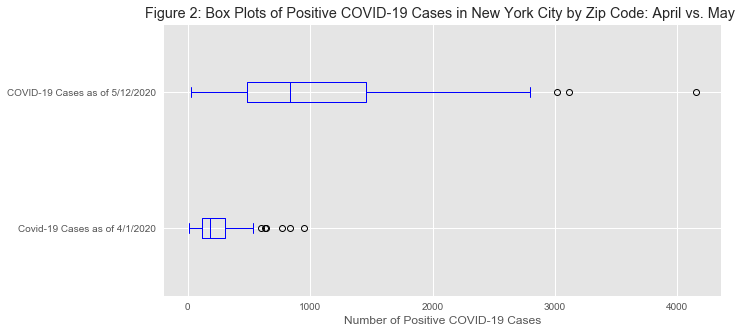

In [62]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style

df_reg=pd.read_pickle(r"C:\Users\ianpa\Desktop\Work\Learning\IBM\Data\saved\df_reg_20200512_nogas.pkl")
zips=list(df_reg['ZIP'])
df_box=df_reg[['cases_april', 'cases_may']]
df_box.rename(columns={"cases_april": "Covid-19 Cases as of 4/1/2020", "cases_may": "COVID-19 Cases as of 5/12/2020"}, inplace=True)

# horizontal box plots
df_box.plot(kind='box', figsize=(10, 5), color='blue', vert=False)

plt.title('Figure 2: Box Plots of Positive COVID-19 Cases in New York City by Zip Code: April vs. May ')
plt.xlabel('Number of Positive COVID-19 Cases')

plt.show()

$\;\;\;\;\;\;$A number of observations can be immediately gleaned from this plot. First of all, this graph illustrates the rapid transmission of the virus between April and May. On April 1st the median number of positive cases was 182, while in May it had swelled to 818. This underscores the importance of the New York state lockdown, as the disparity between these numbers would likely be much greater had it not been implemented. Secondly, both distributions have a number of outliers which likely represent the more densely populated zip codes of NYC. To further investigate this relationship I generate a scatter plot of positive COVID-19 cases in April and population, and overlay a simple regression line:

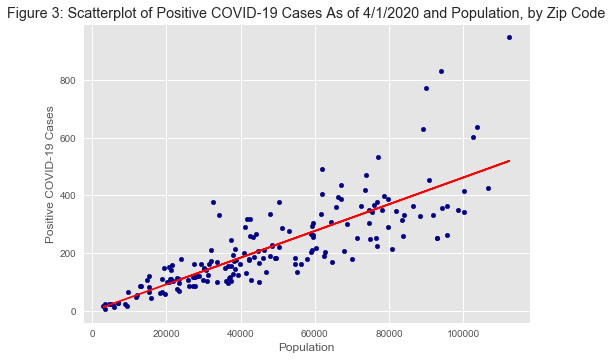

In [63]:
x = df_reg['Population']      # year on x-axis
y = df_reg['cases_april']     # total on y-axis
fit = np.polyfit(x, y, deg=1)
df_reg.plot(kind='scatter', x='Population', y='cases_april', color='darkblue') #figsize=(10, 6),

plt.title('Figure 3: Scatterplot of Positive COVID-19 Cases As of 4/1/2020 and Population, by Zip Code')
plt.xlabel('Population')
plt.ylabel('Positive COVID-19 Cases')

# plot line of best fit
plt.plot(x, fit[0] * x + fit[1], color='red') 
plt.show()

$\;\;\;\;\;\;$The figure above illustrates 2 important points. First of all, there is in fact a strong, linear relationship between COVID-19 cases and population which should be incorporated in the regression analysis. Secondly, the variation in positive cases appears to increase as the population increases, and as a result this heteroskedasticity is accounted for in the models derived below.

#### Regression Analysis ####

$\;\;\;\;\;\;$As an initial step in understanding the factors that explain COVID-19 transmission in NYC I run an OLS regression with total positive COVID-19 cases as of 4/1/2020, the earliest date available by zip code, as the dependent variable. As mentioned in the introduction, the earliest data is utilized in order to curtail the confounding effect of the lockdown, which was implemented in New York state on March 22nd. The independent variables are the total population and the total number of different types of venues, as categorized above. Heteroskedasticity robust standard errors are employed to minimize the risk of biased inference. 

**Model 1: OLS With Total Positive COVID-19 Cases as of 4/1/2020 as the Dependent Variable**

In [51]:
import statsmodels.api as sm
df_reg=pd.read_pickle(r"C:\Users\ianpa\Desktop\Work\Learning\IBM\Data\saved\df_reg_20200512_nogas.pkl")

#ols April: absolute
y_april=df_reg["cases_april"]

X1 = df_reg[["Population","Transportation", "Market", "Store", "Restaurant", "Bar", "Recreation", "Hotel"]]
X2 = df_reg[["Population", "Transportation", "Restaurant", "Bar", "Recreation"]]

ols_april = sm.OLS(y_april, sm.add_constant(X1)).fit(cov_type='HC1')
ols_april.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            cases_april   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     33.25
Date:                Sat, 16 May 2020   Prob (F-statistic):           5.93e-31
Time:                        17:03:30   Log-Likelihood:                -1036.5
No. Observations:                 177   AIC:                             2091.
Df Residuals:                     168   BIC:                             2120.
Df Model:                           8                                         
Covariance Type:                  HC1                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             18.3585     14.528      1.264      0.206     -10.116      46.833
Population         0.0046      0.000     11.786      0.000       0.004       0.005
Transportation     9.5589      5.239      1.824      0.068      -0.710      19.828
Market            -1.5881      3.870     -0.410      0.682      -9.173       5.997
Store              1.0507      1.209      0.869      0.385      -1.320       3.421
Restaurant        -0.5907      0.850     -0.695      0.487      -2.257       1.076
Bar               -1.6078      2.694     -0.597      0.551      -6.888       3.673
Recreation        -2.4081      1.020     -2.362      0.018      -4.407      -0.410
Hotel             10.5180      5.595      1.880      0.060      -0.448      21.484
==============================================================================
Omnibus:                       85.862   Durbin-Watson:                   1.316
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              419.094
Skew:                           1.804   Prob(JB):                     9.88e-92
Kurtosis:                       9.618   Cond. No.                     1.47e+05
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 1.47e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

$\;\;\;\;\;\;$Given that a warning regarding potential multicollinearity was raised, I calculate the variance inflation factor (VIF) for each of the independent variables, displayed in the cell below. A widely utilized rule of thumb is that the VIF for each variable should be below 10, which is indeed the case. 

In [52]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
#Multicollinearity check
X1_check=sm.add_constant(X1)
pd.Series([variance_inflation_factor(X1_check.values, i)
           for i in range(X1_check.shape[1])], 
           index=X1_check.columns)

const             7.099574
Population        1.261970
Transportation    1.099104
Market            1.446550
Store             2.025791
Restaurant        3.737037
Bar               2.438288
Recreation        2.652828
Hotel             2.034518
dtype: float64

$\;\;\;\;\;\;$ Returning to the results from Model 1, it is evident from the z-statistics that the population of a given zip code is the single best predictor of how many positive COVID-19 cases are observed. The generally accepted norm is that a z statistic greater than 1.96 in absolute value implies statistical significance. The z-statistic for **Population** is 11.786, and the corresponding p-value is .000. This means that, with repeated sampling from the data generating process, the probability of observing an effect at least as large, given that there is no relationship between COVID-19 cases and population, is 0.0%! **Transportation** is significant at the 6.8% level, which seems reasonable given that transportation hubs often have large concentrations of people, and are therefore favorable environments for disease transmission. Moreover, many residents of the city continued to rely on public transportation for their work commute in April, despite the lockdown being instituted on March 22nd. It should be noted, however, that statistical significance is distinct from practical significance, and the latter may in fact be of more interest to policymakers. For example, the coefficient on **Hotel** implies that an additional hotel in a zip code, *ceteris paribus*, will lead to roughly an additional 10.5 positive cases of COVID-19, on average. While this effect is not statistically significant, it should nevertheless be taken into account when designing preventative measures to be implemented within the hospitality industry.<br>
$\;\;\;\;\;\;$ Interestingly, **Market** and **Store** do not appear to be important predictors of the spread of the virus, and this is empirically verified by the results of a LASSO regression, shown below. LASSO is a type of penalised regression in which the sum of the absolute value of the regression coefficients is constrained to be less than a constant, which is equivalent to imposing a double exponential prior, centered at zero, on the coefficients. This often results in the "shrinking" of coefficient estimates. As can be seen from the results below, when this technique is implemented with 10-fold cross-validation, and the tuning parameter is optimized using a grid search, the coefficients on **Market** (x3) and **Store** (x4) are shrunk to 0. It should be noted that the inferences made in the following models below are robust to the ommission of these variables.

In [53]:
import sys
!{sys.executable} -m pip install numpy scipy
!{sys.executable} -m pip install regressors
from regressors import stats
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

lasso = Lasso(max_iter = 10000, normalize = True)
lassocv = LassoCV(alphas = None, cv = 5, max_iter = 100000, normalize = True)
lassocv.fit(X1, y_april)
print(lassocv.alpha_)
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X1,y_april)
stats.summary(lasso, X1, y_april)

0.2635020508814171
Residuals:
    Min        1Q    Median        3Q       Max
-4.3078  122.9308  202.4412  317.8438  511.6978


Coefficients:
             Estimate  Std. Error  t value   p value
_intercept  21.216209   16.995152   1.2484  0.213554
x1           0.004404    0.000117  37.5089  0.000000
x2           6.560233    5.813159   1.1285  0.260639
x3          -0.000000    3.818301  -0.0000  1.000000
x4           0.000000    1.414302   0.0000  1.000000
x5          -0.125576    0.515921  -0.2434  0.807978
x6          -2.161661    2.405615  -0.8986  0.370099
x7          -1.235781    1.105751  -1.1176  0.265263
x8           0.000000    8.654422   0.0000  1.000000
---
R-squared:  0.68368,    Adjusted R-squared:  0.66862
F-statistic: 45.39 on 8 features


$\;\;\;\;\;\;$A legitimate concern for Model 1 is that inference may be biased by the fact that, for various reasons, access to testing was greater in some zip codes as opposed to others. As of May 12th, 1,182,998 people in the entire state of New York have been tested for the virus, which is roughly 61 tests per 1,000 people. It seems reasonable to think that, given the dearth of resources available for testing, some areas in NYC would have greater access than others. To alleviate this concern, I also run an OLS regression in which the dependent variable is the proportion of people testing positive for the virus, out of the total number of tests administered, in a given zip code while retaining a control for total population:

**Model 2: OLS With Proportion of Positive COVID-19 Cases as of 4/1/2020 as the Dependent Variable**

In [69]:
#ols April: proportion
df_reg['Prop_april']=df['cases_april']/df['tests_april']
y_april_prop=df_reg['Prop_april']
ols_april_prop=sm.OLS(y_april_prop, sm.add_constant(X1)).fit(cov_type='HC1')
ols_april_prop_pred=ols_april_prop.predict(sm.add_constant(X1))
ols_april_prop.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Prop_april   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     17.93
Date:                Sat, 16 May 2020   Prob (F-statistic):           3.26e-19
Time:                        18:49:42   Log-Likelihood:                 213.06
No. Observations:                 177   AIC:                            -408.1
Df Residuals:                     168   BIC:                            -379.5
Df Model:                           8                                         
Covariance Type:                  HC1                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.5128      0.017     29.789      0.000       0.479       0.547
Population      8.386e-07   2.65e-07      3.159      0.002    3.18e-07    1.36e-06
Transportation     0.0090      0.005      1.956      0.051   -2.04e-05       0.018
Market             0.0016      0.003      0.506      0.613      -0.005       0.008
Store              0.0010      0.001      0.908      0.364      -0.001       0.003
Restaurant        -0.0017      0.001     -2.443      0.015      -0.003      -0.000
Bar                0.0022      0.002      0.958      0.338      -0.002       0.007
Recreation        -0.0053      0.001     -3.981      0.000      -0.008      -0.003
Hotel              0.0029      0.007      0.436      0.663      -0.010       0.016
==============================================================================
Omnibus:                        1.928   Durbin-Watson:                   1.269
Prob(Omnibus):                  0.381   Jarque-Bera (JB):                1.807
Skew:                           0.247   Prob(JB):                        0.405
Kurtosis:                       2.976   Cond. No.                     1.47e+05
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 1.47e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

$\;\;\;\;\;\;$ As illustrated by the table above, the inferences garnered from this model are radically different, and cast significant doubt on the results obtained in Model 1. While **Population** has retained its statistical significance, the importance of the number of hotels in a given zip code is dramatically reduced, which accords with the results of the LASSO regression above. Moreover, the number of restaurants in a given zip code is now a significant, negative predictor in the model.  Finally, the coefficient on **Transportation** is barely below the generally accepted significance threshold, and is now significant at the 5.1% level. The robustness of this result suggests that it is in fact an important predictor of COVID-19 transmission in NYC.
<br>
$\;\;\;\;\;\;$It should be noted, however, that an OLS regression with a proportion as the dependent variable can potentially render misleading results. First of all, predicted values from such models may not necessarily lie within the interval [0,1]. Secondly, such models may violate the normality assumption, as well as the linearity assumption necessary for the Gauss-Markov theorem to be applicable. Nevertheless, such models can be instructive if handled with care. As a beginning step to determine whether the model is appropriate, I examine the true and predicted values for the proportion of positive COVID-19 cases obtained. Forunately the true proportion varies along a very restricted invertal, with a minimum of 0.25 and a maximum of 0.77; which suggests that a linear model may still be correct. Furthermore, due to this clustering of the data none of the predicted values fall outside the [0,1] interval, as can be seen in the table below:

In [75]:
df_reg['Predicted Proportion']=ols_april_prop_pred
df_disp=df_reg[['Prop_april']]
df_disp['Predicted Value']=ols_april_prop_pred
df_disp.rename(columns={"Prop_april": "True Proportion"}, inplace=True)
df_disp.describe()

C:\Users\ianpa\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ianpa\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


True Proportion  Predicted Value
count       177.000000       177.000000
mean          0.511840         0.511840
std           0.094573         0.060348
min           0.250000         0.292168
25%           0.441088         0.487906
50%           0.513761         0.526948
75%           0.576068         0.555963
max           0.771801         0.601539

$\;\;\;\;\;\;$To further assess the appropriateness of OLS in this instance, I analyze 2 commonly utilized diagnostic plots. In order to gauge the linearity assumption I plot the studentized residuals from our model against the fitted values. If the model is well specified, this plot will look like random noise, with a fitted red line that is roughly horizontal; otherwise, we are underfitting the model and not capturing non-linearities in the data. Secondly, in order to determine the plausibility of the normality assumption I employ a normal Q-Q plot, which graphs the studentized residuals against the expected order statistics of the standard normal distribution. If the normality assumption is appropriate, the studentized residuals will fall on the line y=x (the line in red).

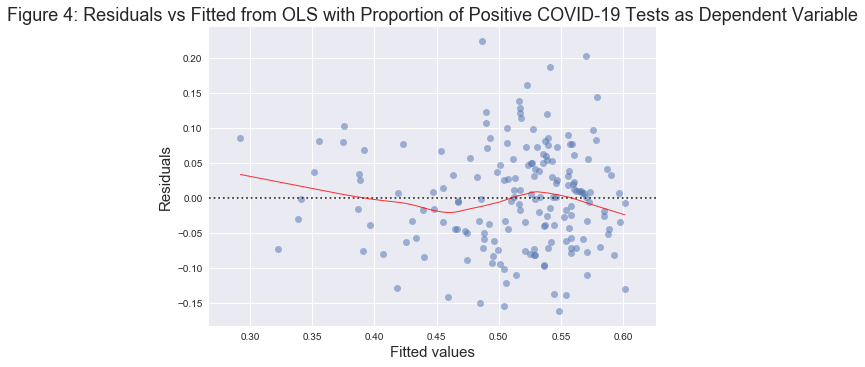

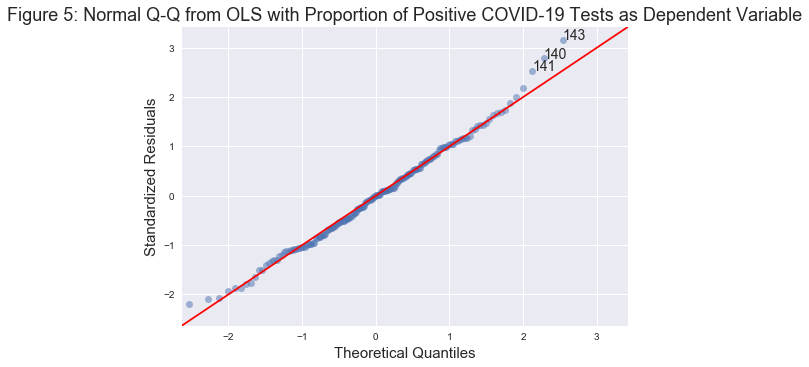

In [76]:
import seaborn as sns
from statsmodels.graphics.gofplots import ProbPlot
plt.style.use('seaborn') # pretty matplotlib plots
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

y=y_april_prop
model = sm.OLS(y, sm.add_constant(X1))
model_fit=model.fit(cov_type='HC1')
dataframe=pd.concat([X1, y], axis=1)

# model values
model_fitted_y = model_fit.fittedvalues
# model residuals
model_residuals = model_fit.resid
# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, dataframe.columns[-1], data=dataframe,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Figure 4: Residuals vs Fitted from OLS with Proportion of Positive COVID-19 Tests as Dependent Variable')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Figure 5: Normal Q-Q from OLS with Proportion of Positive COVID-19 Tests as Dependent Variable')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i,
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

$\;\;\;\;\;\;$Both of these plots cast serious doubt on the appropriateness of OLS in this instance. As we can see from Figure 5, the normality assumption does not appear to hold in the tails of the distribution. Moreover, Figure 4 indicates that there are in fact non-linearities which are not being captured in Model 2. Once again, and as is often the case in such settings, the tails of the distribution are most problematic. Taken together, this suggests that a non-linear model is more appropriate when anlayzing the proportion of positive COVID-19 tests. As an improvement I employ a method proposed by Papke and Wooldridge (1996) in which a generalized linear model is utilized with robust standard errors. This approach makes use of the logit link function (that is, the logit transformation of the response variable) and the binomial distribution, which is the proper choice of family given this particular setting, as testing for COVID-19 can be thought of as a sequence of Bernoulli trials.

**Model 3: GLM with Logit Link Function and Binomial Distribution**

In [57]:
#glm april prop
glm_april_prop = sm.GLM(y_april_prop, sm.add_constant(X1), family=sm.families.Binomial())
glm_april_results=glm_april_prop.fit(cov_type='HC1')
glm_april_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             Prop_april   No. Observations:                  177
Model:                            GLM   Df Residuals:                      168
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -80.086
Date:                Sat, 16 May 2020   Deviance:                       3.8218
Time:                        17:04:27   Pearson chi2:                     3.77
No. Iterations:                     3                                         
Covariance Type:                  HC1                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0524      0.068      0.772      0.440      -0.081       0.185
Population      3.368e-06   1.05e-06      3.197      0.001     1.3e-06    5.43e-06
Transportation     0.0365      0.018      2.019      0.044       0.001       0.072
Market             0.0068      0.013      0.536      0.592      -0.018       0.032
Store              0.0040      0.004      0.941      0.347      -0.004       0.012
Restaurant        -0.0070      0.003     -2.488      0.013      -0.013      -0.001
Bar                0.0090      0.009      1.009      0.313      -0.009       0.027
Recreation        -0.0218      0.005     -4.021      0.000      -0.032      -0.011
Hotel              0.0123      0.027      0.454      0.650      -0.041       0.066
==================================================================================
"""

$\;\;\;\;\;\;$As is evident from the table, the use of the approach advocated by Papke and Wooldridge (1996) does not qualitatively affect most of the the inference. The variables **Population**, **Recreation**, and **Restaurant** continue to be statistically significant predictors in the model. However, an important result for policymakers is that **Transportation** is also now statistically significant. In repeated sampling we would observe an effect at least as large, if there were no relationship between transportation terminals and the proportion of positive COVID-19 tests, only 4.4% of the time. These results lend important insights into how and which venues in NYC can be re-opened while still maintaining a tolerable risk of virus transmission. In the case of transportation hubs, it also suggests that trenchant measures should be taken to ensure the safety of these areas.<br>
$\;\;\;\;\;\;$ As a final step in the analysis I investigate the factors that explain the growth rate in positive COVID-19 cases over time. Model 4 shown below displays the results of an OLS regression in which this growth rate, calculated over the period 4/1/2020 - 5/12/2020, is taken as the dependent variable and the same set of independent variables are utilized. No transformation is applied to the data, as the growth in positive cases appears to be largely linear, and is certainly not exponential in a manner that would require logarithmic scaling. This can be seen in Figure 6 below, which plots positive COVID-19 cases as of 5/12/2020 against positive COVID-19 cases as of 4/1/2020, with a quadratic polynomial fitted to the data.

Text(0, 0.5, 'Positive COVID-19 Cases as of 5/12/2020')

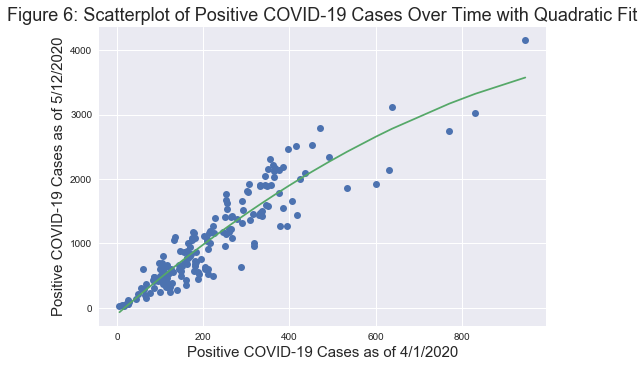

In [58]:
x=np.array(df_reg['cases_april'])
y=np.array(df_reg['cases_may'])
fit = np.poly1d(np.polyfit(x, y, deg=2))
plt.plot(x,y,'o')
sorted=np.sort(x)
plt.plot(sorted,fit(sorted))
plt.title('Figure 6: Scatterplot of Positive COVID-19 Cases Over Time with Quadratic Fit')
plt.xlabel('Positive COVID-19 Cases as of 4/1/2020')
plt.ylabel('Positive COVID-19 Cases as of 5/12/2020')

**Model 4: OLS With Growth Rate in COVID-19 Cases Between 4/1/2020 and 5/12/2020 as the Dependent Variable**

In [77]:
#Generate new dependent variable
df_reg['Growth Rate']=(df_reg['cases_may']-df_reg['cases_april'])/df_reg['cases_april']

#define model
y_growth=(df_reg['Growth Rate'])
ols_growth = sm.OLS(y_growth, sm.add_constant(X1)).fit(cov_type='HC1') 

# Print out the statistics
ols_growth.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Growth Rate   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     24.97
Date:                Sat, 16 May 2020   Prob (F-statistic):           4.55e-25
Time:                        19:04:06   Log-Likelihood:                -259.21
No. Observations:                 177   AIC:                             536.4
Df Residuals:                     168   BIC:                             565.0
Df Model:                           8                                         
Covariance Type:                  HC1                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.0041      0.235     17.029      0.000       3.543       4.465
Population      7.222e-06   3.37e-06      2.143      0.032    6.17e-07    1.38e-05
Transportation    -0.0229      0.086     -0.264      0.791      -0.192       0.147
Market             0.0397      0.045      0.880      0.379      -0.049       0.128
Store              0.0046      0.023      0.204      0.839      -0.040       0.049
Restaurant        -0.0201      0.008     -2.378      0.017      -0.037      -0.004
Bar               -0.0464      0.024     -1.926      0.054      -0.094       0.001
Recreation        -0.0532      0.017     -3.194      0.001      -0.086      -0.021
Hotel             -0.0866      0.091     -0.953      0.341      -0.265       0.092
==============================================================================
Omnibus:                       34.543   Durbin-Watson:                   1.679
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.706
Skew:                           0.840   Prob(JB):                     1.81e-18
Kurtosis:                       5.873   Cond. No.                     1.47e+05
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 1.47e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

$\;\;\;\;\;\;$As one would expect, the population of a given zip code remains a statistically significant covariate in the model. In addition, the table above illustrates that **Restaurant** and **Recreation** are negatively correlated with the growth rate of COVID-19 cases over this time period, which underscores the efficacy of the shutdown measures enacted in the city.


## Conclusion


$\;\;\;\;\;\;$The COVID-19 pandemic has had a dramatic impact on the economic, social and personal lives of Americans across the country. Due to a variety of factors including population density and economic scale, this effect has perhaps been most keenly felt in New York City. According to the NYC Department of Health and Mental Hygiene (DOHMH), the number of confirmed deaths attributed to the virus is at least 15,253, with another 5,051 deaths "probably" due to the same cause. This represents 17.3% - 23.0% of all deaths in the United States due to the virus. The state-wide closure of all businesses deemed to be non-essential, while clearly efficacious in curbing the spread of the disease, has also had a devestating effect on the livelihoods of many New Yorkers. According to the New York Times, city officials estimate that half of the hotels in the city are not operating, and some 186,000 shops employing fewer than 10 people could fail. This has spurned an intense debate over whether shuttered businesses should be allowed to re-open and, if so, how to accomplish this in a manner that does not unnecessarily put additional lives at risk. This discussion highlights the importance of understanding which factors contributed to the transmission of the virus in the first place, so that these insights can be incorporated into a reasoned plan for resuming normal economic and social activities.<br>
$\;\;\;\;\;\;$To that end, the foregoing analysis employed a regression framework to investigate the categories of business venues most strongly associated with positive COVID-19 cases as of 4/1/2020, the earliest date for which zip code-level data were available. The number of transportation hubs in a given zip code was identified as a statistically significant predictor of the proportion of positive tests using the preferred GLM model; in addition, it was statistically significant at the 5.1% level using OLS. Interestingly, the number of restaurants, bars, and recreational venues in a zip code did not have a positive, statistically significant impact on the proportion of COVID-19 positive cases. Moreover, these venues did not have a positive, statistically significant impact on the growth rates in cases. These insights are of particular utility to policymakers tasked with managing the timing and form of the resumption of normal economic activity in the city.

## References##

[1] Leslie E. Papke and Jeffrey M. Wooldridge, "Econometric Methods for Fractional Response Variables with an Application to 410(k) Plan Participation Rates," *Journal of Applied Econometrics* 11, no. 6 (November 1996): 619-632. <br>
[2] J. David Goodman. "I Don't Think the New York That We Left Will Be Back For Some Years." New York Times, May 6, 2020. https://www.nytimes.com/2020/04/20/nyregion/new-york-economy-coronavirus.html. <br>
[3] Mayra Rodriguez Valladares. "New York State Unemployment Rate Is At Highest Level Since the Great Depression." Forbes, April 26, 2020. https://www.forbes.com/sites/mayrarodriguezvalladares/2020/04/26/new-york-state-unemployment-rate-is-at-highest-level-since-the-great-depression/#359cbc3076f2.

